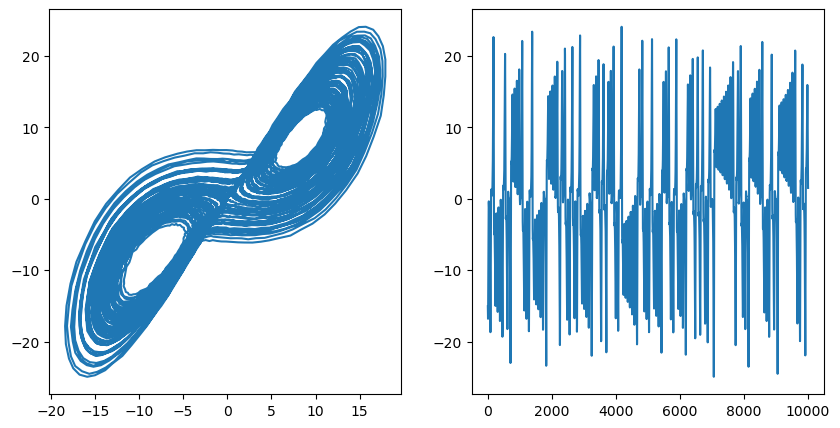

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz

## Load and simulate an attractor
model = Lorenz()
model.dt = 0.01
sol = model.make_trajectory(10000, resample=False, noise=0.00)


sol += np.random.normal(0, 0.05, sol.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[1].plot(sol[:10000, 1])



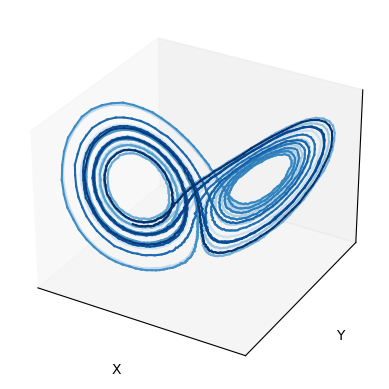

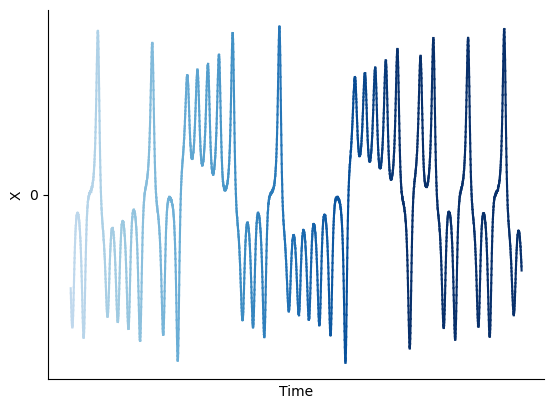

In [41]:
#plot in 3d
time = 10_000
dt = 0.01


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = 3000
s = 1

cm = plt.get_cmap('Blues')
for j in range(i):
    ax.plot(sol[j:j+2, 0], sol[j:j+2, 1], sol[j:j+2, 2], color=cm((j+100)/(i+10)))
# ax.plot(sol[:i:s, 0], sol[:i:s, 1], sol[:i:s, 2])
#remove backdrop
# ax.set_axis_off()
ax.grid(False)
#remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.figure()
for j in range(i):
    plt.plot(np.arange(j,(j+2)),sol[j:j+2, 0],color=cm((j+800)/(i+10)))
plt.xlabel('Time')
plt.ylabel('X')
#remove top and right bars
plt.gca().spines['top'].set_visible(False)
plt.yticks([0.0])
plt.xticks([])
plt.gca().spines['right'].set_visible(False)
#save as pdf
plt.savefig('lorenz.pdf', format='pdf')

In [4]:
import torch


def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.

    Parameters
    ----------
    data : torch.tensor
        The data from which to create the delay embedding. Must be either: (1) a
        2-dimensional array/tensor of shape T x N where T is the number
        of time points and N is the number of observed dimensions
        at each time point, or (2) a 3-dimensional array/tensor of shape
        K x T x N where K is the number of "trials" and T and N are
        as defined above.

    n_delays : int
        Parameter that controls the size of the delay embedding. Explicitly,
        the number of delays to include.

    delay_interval : int
        The number of time steps between each delay in the delay embedding. Defaults
        to 1 time step.
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    device = data.device

    if data.shape[int(data.ndim == 3)] - (n_delays - 1) * delay_interval < 1:
        raise ValueError(
            "The number of delays is too large for the number of time points in the data!"
        )

    # initialize the embedding
    if data.ndim == 3:
        embedding = torch.zeros(
            (
                data.shape[0],
                data.shape[1] - (n_delays - 1) * delay_interval,
                data.shape[2] * n_delays,
            )
        ).to(device)
    else:
        embedding = torch.zeros(
            (data.shape[0] - (n_delays - 1) * delay_interval, data.shape[1] * n_delays)
        ).to(device)

    for d in range(n_delays):
        index = (n_delays - 1 - d) * delay_interval
        ddelay = d * delay_interval

        if data.ndim == 3:
            ddata = d * data.shape[2]
            embedding[:, :, ddata : ddata + data.shape[2]] = data[
                :, index : data.shape[1] - ddelay
            ]
        else:
            ddata = d * data.shape[1]
            embedding[:, ddata : ddata + data.shape[1]] = data[
                index : data.shape[0] - ddelay
            ]

    return embedding

torch.Size([9901, 100])


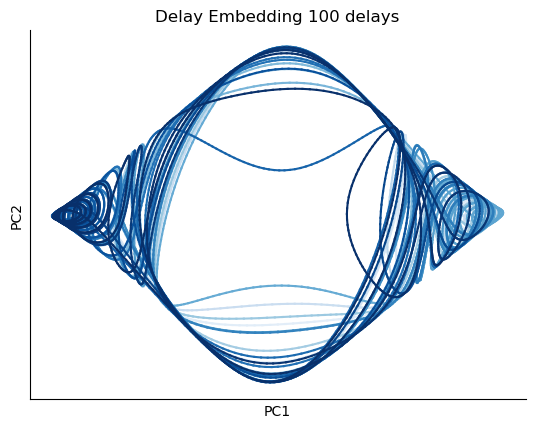

In [37]:
n_delays = 100
delay_interval = 1

cmap = plt.get_cmap('Blues')
H = embed_signal_torch(sol[:, 0:1], n_delays, delay_interval)
print(H.shape)
U, S, V = torch.svd(H.T)

V = V.cpu().numpy()

num_segments = V.shape[0] - 1

for i in range(num_segments):
    plt.plot(V[i : i + 2, 0], V[i : i + 2, 1], color=cmap((i+1000) / num_segments))
# plt.plot(V[:, 0], V[:, 1])
plt.title(f"Delay Embedding {n_delays} delays")
plt.xlabel("PC1")
plt.ylabel("PC2")
#remove ticks
plt.xticks([])
plt.yticks([])
#remove grid lines
plt.grid(False)
#remove borders on top and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(f"delay_embedding{n_delays}.pdf")

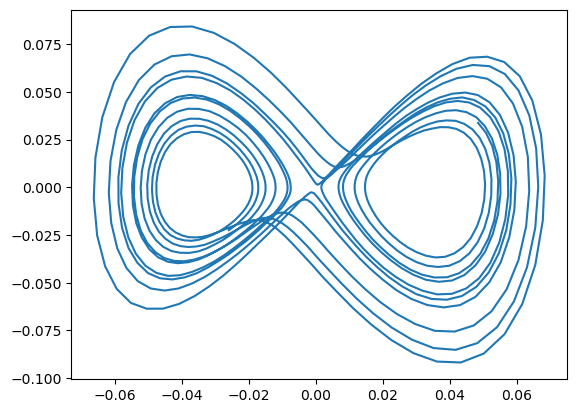

In [5]:
plt.plot(V[:, 0], V[:, 1])